# Sumo Match-Fixing in Modern Times

### Ethan Williams
### March 4, 2020


### Abstract

This paper analysis current Sumo wrestling statistics using machine learning algorithms to determine if there is a possibility of match-fixing still going on in current day Sumo. Previously I have examined the 80s and 90s to find first, that there was indeed match fixing occurring, and second, a list of the rikishi that were almost surely participating in match-fixing (having a <3% chance of getting the results they did). I will use this as a baseline for the machine learning algorithms.


## Problem Statement and Motivation

Sumo has been plagued with accusations of match fixing for decades at this point. As recently as 2011, there have been rikishi kicked out of the JSA (Japan Sumo Association) on the grounds that they were found guilty of match-fixing. During the 80s and 90s match-fixing abounded and no rikishi were ever caught or investigated. A previous paper I did gave a list of those who were most likely to have participated in match-fixing based only off of the results of 7-7 matches, that is matches where on the last day of the tournament one of the rikishi had a 7-7 record. The 7-7 record is important because if the rikishi were to lose the next match, he would lose rank (and therefor salary). Thus this creates motivation to fix these matches in particular. 
Thus I can compare data from known match-fixers to those who are currently competing to see if there enough similarities to conclude that they are also match-fixing.

## Data

The Data was obtained from data.world uploaded by a user by the name of MIKHAIL ZHILKIN. He scraped the data from the website sumodb.sumogames.de which is one of the most comprehensive databases on sumo information on the internet. Various sources are used as reference (nowadays often video) and the older results are pulled from old sumo magazines or old newspapers. Results are entered by a dedicated few individuals, and verified by many different users. Mistakes are possible but since the website has been up since around 2007, it is unlikely that any results are incorrect. 

## Ethics

Match-fixing has serious real-world implications for the rikishi found participating in it. Those found guilty are fined and expelled from competing again. This means a change in occupation, social shunning for the rikishi, as well as dishonor brougth upon the sport of Sumo as a whole. While these algorithms may classify certain rikishi as cheaters or not, it is certainly not 100% accurate and typical investigations must be followed before any action is taken. 

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import re
import csv
import matplotlib.pyplot as plt
import collections
plt.style.use("seaborn-darkgrid")

In [2]:
#just a note, much of this code is from last semesters project and will not be shown in this project.


matches = pd.read_csv("cervus-sumo-results/data/1983.csv")
for a in range(1984,2020):
    matches = pd.concat((matches,pd.read_csv("cervus-sumo-results/data/"+str(a)+".csv")))
    

#dropping every other row
matches = matches.iloc[::2,:]
#make the date (year and month) the index
matches["basho"] = matches["basho"].astype(str)
#make the indices of the dataframe a month and year
matches.index = pd.to_datetime(matches["basho"],format="%Y.%m")
regular = re.compile(r"^(\d\d?)-(\d\d?) \((\d\d?)-\d?-?(\d\d?)\)")
#with this regular expression i can use the same one for every entry
#this regular expression breaks on day 15, but doesn't raise any errors, as well as we don't need to
#look at those columns on day 15 as all the data we need is in the row on day 14
#the only data we'll need to get from day 15 eventually is who their opponent was
results1 = matches["rikishi1_result"].tolist()
results2 = matches["rikishi2_result"].tolist()
total1, total2, win1, win2, losstotal1, losstotal2, loss1, loss2 = [],[],[],[],[],[],[],[]
for a in range(len(results1)):
    total1.append(regular.sub(r"\3",results1[a]))
    total2.append(regular.sub(r"\3",results2[a]))
    win1.append(regular.sub(r"\1",results1[a]))
    win2.append(regular.sub(r"\1",results2[a]))
    loss1.append(regular.sub(r"\2",results1[a]))
    loss2.append(regular.sub(r"\2",results2[a]))
    losstotal1.append(regular.sub(r"\4",results1[a]))
    losstotal2.append(regular.sub(r"\4",results2[a]))
matches["rikishi1_totalwins"] = total1
matches["rikishi1_totallosses"] = losstotal1
matches["rikishi1_wins"] = win1
matches["rikishi1_losses"] = loss1
matches["rikishi2_totalwins"] = total2
matches["rikishi2_totallosses"] = losstotal2
matches["rikishi2_wins"] = win2
matches["rikishi2_losses"] = loss2

#i'll loop through the whole dataframe, but we'll do it more effectively by only checking the 14th day matches of each basho
bashos = matches.index.unique()
frame = []
for i in bashos:
    #each list will be reset for each basho
    #list of IDs of rikishi who lost to a 7-7 rikishi on the last day
    win77losers =[] 
    #list of IDs of rikishi who had a 7-7 record then won the last match
    win77winners = [] 
    #list of IDs of rikishi who had a 7-7 record then lost the last match
    loss77losers = [] 
    #list of IDs of rikishi who beat a rikishi that was 7-7
    loss77winners = [] 
    #total number of 7-7 matches for each basho
    match77 = 0 
    #number of 7-7 matches that resulted in a win for the 7-7 rikihsi
    match77win =0
    #number of 7-7 matches that resulted in a loss for the 7-7 rikishi
    match77loss = 0 
    #partial dataframes that contain only day 14 and 15 of the current basho
    current = matches[matches.index==i]
    current = current[current['day']==14]
    opponent_check = matches[matches.index==i]
    opponent_check = opponent_check[opponent_check['day'] == 15]
    for index,x in current.iterrows():
        #check the rikishi1_wins and rikishi2_wins columns of every row to search for 7-7 rikishi
        if (x['rikishi1_wins'] == '7') & (x['rikishi1_losses'] == '7'):
            #add the match to the total 7-7 matches
            match77 += 1 
            #check wether the rikishi then won or lost
            #then record the IDs of that rikishi and his opponent
            if x['rikishi1_totalwins'] == '8':
                #increase the win counter
                match77win+=1
                for index2,y in opponent_check.iterrows():
                    #find the ID of the opponent then add it to the opposite list
                    if y['rikishi1_id'] == x['rikishi1_id']:
                        win77losers.append(y['rikishi2_id'])
                    elif y['rikishi2_id'] == x['rikishi1_id']:
                        win77losers.append(y['rikishi1_id'])
                #add the rikishi's ID to the list
                win77winners.append(x.rikishi1_id)
            if x['rikishi1_totalwins'] == '7':
                #increase the loss counter
                match77loss+=1
                for index2,y in opponent_check.iterrows():
                    #find the ID of the opponent then add it to the opposite list
                    if y['rikishi1_id'] == x['rikishi1_id']:
                        loss77winners.append(y['rikishi2_id'])
                    elif y['rikishi2_id'] == x['rikishi1_id']:
                        loss77winners.append(y['rikishi1_id'])
                #add the rikishi's ID to the list
                loss77losers.append(x.rikishi1_id)
        #this code is the same as the first block, but checks the other column of rikishi
        if (x['rikishi2_wins'] == '7') & (x['rikishi2_losses'] == '7'):
            match77 += 1 
            if x['rikishi2_totalwins'] == '8':
                match77win+=1
                for index2,y in opponent_check.iterrows():
                    if y['rikishi1_id'] == x['rikishi2_id']:
                        win77losers.append(y['rikishi2_id'])
                    elif y['rikishi2_id'] == x['rikishi2_id']:
                        win77losers.append(y['rikishi1_id'])
                win77winners.append(x.rikishi2_id)
            if x['rikishi2_totalwins'] == '7':    
                match77loss+=1
                for index2,y in opponent_check.iterrows():
                    if y['rikishi1_id'] == x['rikishi2_id']:
                        loss77winners.append(y['rikishi2_id'])
                    elif y['rikishi2_id'] == x['rikishi2_id']:
                        loss77winners.append(y['rikishi1_id'])
                loss77losers.append(x.rikishi2_id)
    frame.append(tuple((i, match77, match77win, match77loss, win77winners, win77losers, loss77winners, loss77losers)))

    
winning = collections.Counter()
for basho in frame:
    for x in basho[4]:
        winning[x]+=1
    for x in basho[5]:
        winning[x]+=1
losing = collections.Counter()
for basho in frame:
    for x in basho[6]:
        losing[x]+=1
    for x in basho[7]:
        losing[x]+=1


In [3]:
reader = csv.reader(open('sumo_dict.csv', 'r'))
#read in all rikishi names and id's
names = {}
for row in reader:
    k, v = row
    names[k] = v
prevcheaters = [(45, 11, 3, 0.028693502589508424), (27, 9, 2, 0.02240181875876912), (4100, 9, 2, 0.02240181875876912), (1295, 14, 4, 0.022295114340775468), (63, 6, 1, 0.022079841675520018), (35, 6, 1, 0.022079841675520018), (3, 6, 1, 0.022079841675520018), (4102, 6, 1, 0.022079841675520018), (1292, 27, 10, 0.01985823105422102), (1333, 17, 5, 0.01707072164430945), (28, 26, 9, 0.014680938517870445), (25, 10, 2, 0.01404249392809298), (1380, 10, 2, 0.01404249392809298), (1289, 7, 1, 0.012806308171801617), (1297, 7, 1, 0.012806308171801617), (1287, 16, 4, 0.010170370115304306), (16, 11, 2, 0.008753321126138025), (42, 11, 2, 0.008753321126138025), (1309, 11, 2, 0.008753321126138025), (1378, 11, 2, 0.008753321126138025), (1369, 14, 3, 0.008049647460896758), (4137, 8, 1, 0.0074276587396449045), (62, 12, 2, 0.005429957548909625), (1305, 12, 2, 0.005429957548909625), (1303, 12, 2, 0.005429957548909625), (1352, 12, 2, 0.005429957548909625), (1361, 12, 2, 0.005429957548909625), (1315, 15, 3, 0.0052005540849210385), (1332, 15, 3, 0.0052005540849210385), (4094, 10, 1, 0.002498664400016559), (33, 27, 7, 0.0023947091624823003), (1285, 14, 2, 0.0020641571752334498), (1335, 14, 2, 0.0020641571752334498), (1347, 11, 1, 0.001449225352009642), (1348, 16, 2, 0.0007742840186730771), (1302, 23, 4, 0.0005389856947435323), (1353, 17, 2, 0.0004722561788584878), (1375, 18, 2, 0.00028734802359420275), (4131, 14, 1, 0.00028276125688131426), (37, 26, 4, 0.0001433167986891748)]

oldrikishi ={}
newrikishi = {}
#create a dictionary of only the rikishi between 1983 and 1999
bashos = matches.index.unique()
for a in bashos[:96]:
    current = matches[matches.index==a]
    current = current[current['day']==1]
    for index,x in current.iterrows():
        oldrikishi[x["rikishi2_id"]]=x["rikishi2_shikona"]
        oldrikishi[x["rikishi1_id"]]=x["rikishi1_shikona"]
for a in bashos[96:]:
    current = matches[matches.index==a]
    current = current[current['day']==1]
    for index,x in current.iterrows():
        newrikishi[x["rikishi2_id"]]=x["rikishi2_shikona"]
        newrikishi[x["rikishi1_id"]]=x["rikishi1_shikona"]

In [4]:
banzuke = pd.read_csv("banzuke.csv")
heightsw = banzuke.drop(['basho','rank','rikishi','heya','shusshin','birth_date','prev'],axis=1).groupby('id').mean()


In [5]:
datatrain = []
cheatnocheat = []
previous = [x[0] for x in prevcheaters]
for rikishi in oldrikishi:
    if (rikishi in winning) & (rikishi in losing):
        datatrain.append([rikishi,winning[rikishi],losing[rikishi], winning[rikishi]+losing[rikishi]]+heightsw.loc[rikishi].tolist())
    elif (rikishi in winning) & (rikishi not in losing):
        datatrain.append([rikishi,winning[rikishi],0, winning[rikishi]+0]+heightsw.loc[rikishi].tolist())
        
    elif (rikishi not in winning) & (rikishi in losing):
        datatrain.append([rikishi,0,losing[rikishi], 0+losing[rikishi]]+heightsw.loc[rikishi].tolist())
        
    else:
        datatrain.append([rikishi,0,0,0]+heightsw.loc[rikishi].tolist())
    if rikishi in previous:
            cheatnocheat.append(1)
    else:
            cheatnocheat.append(0)
        


In [6]:
datatrain_x = np.array(datatrain)
datatrain_y = np.array(cheatnocheat)

## UMAP

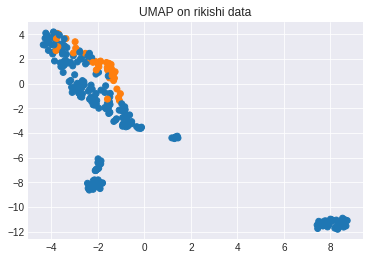

In [7]:
from sklearn.decomposition import PCA
import numpy as np
import sklearn as sk
import umap
from scipy import linalg as la
colors = ["C0","C1","C2","C3","C4","C5","C6","C7","C8","C9"]

embedsumo = umap.UMAP(n_neighbors=40,min_dist=.15,metric="canberra").fit_transform(datatrain_x[:,1:])
plt.scatter(embedsumo[:,0],embedsumo[:,1],color=[colors[x] for x in datatrain_y])
plt.title("UMAP on rikishi data")
plt.savefig("Umapold.pdf")
plt.show()



## t-SNE

In [8]:
tsnesumo = sk.manifold.TSNE(n_components=2,perplexity=11,early_exaggeration=4).fit_transform(datatrain_x[:,1:])
plt.scatter(tsnesumo[:,0],tsnesumo[:,1],color=[colors[x] for x in datatrain_y])
plt.title("t-SNE on rikishi data")
plt.show()

## Spectral Clustering

In [9]:
#very scuffed right now
from sklearn.cluster import SpectralClustering
spectralsumo = SpectralClustering(n_clusters=2,random_state=0).fit_predict(datatrain_x[:,1:])
plt.scatter(embedsumo[:,0],embedsumo[:,1],color=[colors[x] for x in spectralsumo])
plt.title("Spectral Clustering on rikishi data")
plt.show()

/home/ethan/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


## Naive Bayes 

In [53]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.naive_bayes import GaussianNB

TX,tx,TY,ty = train_test_split(datatrain_x[:,1:],datatrain_y,test_size=.4)
gus = GaussianNB()
gus.fit(TX,TY)

predictions = gus.predict_proba(tx)
gaussfpr,gausstpr,_ = roc_curve(ty,predictions[:,1])
plt.plot(gaussfpr,gausstpr,marker='.', label='GaussianNB')
plt.title("Gaussian Naive Bayes ROC curve on test data")
plt.savefig("GaussianNBroc.pdf")
plt.show()
print("AUC score of: {}".format(roc_auc_score(ty,predictions[:,1])))

AUC score of: 0.7275862068965517


In [11]:
new_rikishi_data = []

for rikishi in newrikishi:
    if (rikishi in winning) & (rikishi in losing):
        new_rikishi_data.append([rikishi,winning[rikishi],losing[rikishi], winning[rikishi]+losing[rikishi]]+heightsw.loc[rikishi].tolist())
    elif (rikishi in winning) & (rikishi not in losing):
        new_rikishi_data.append([rikishi,winning[rikishi],0, winning[rikishi]+0]+heightsw.loc[rikishi].tolist())
        
    elif (rikishi not in winning) & (rikishi in losing):
        new_rikishi_data.append([rikishi,0,losing[rikishi], 0+losing[rikishi]]+heightsw.loc[rikishi].tolist())
        
    else:
        new_rikishi_data.append([rikishi,0,0,0]+heightsw.loc[rikishi].tolist())
        


In [12]:
new_rikishi_data = np.array(new_rikishi_data)

In [13]:
gus = GaussianNB()
gus.fit(datatrain_x[:,1:],datatrain_y)
NBpredictions = gus.predict(new_rikishi_data[:,1:])
print("Proposed percentage of match-fixers from 1999-2019: " + str(np.sum(NBpredictions)/len(NBpredictions)))
print("Percentage of match-fixers based only off of 2011 investigation: "+str(23/len(NBpredictions)))
print("Number of proposed cheaters from 1999 to 2019: "+str(np.sum(NBpredictions)))
predicted_cheaters_Gaussian = new_rikishi_data[NBpredictions==1]
cheater_IDs_Gaussian = predicted_cheaters_Gaussian[:,0]
Gaussian_predicted_rikishi = [newrikishi[x] for x in cheater_IDs_Gaussian]
print(Gaussian_predicted_rikishi)

Proposed percentage of match-fixers from 1999-2019: 0.15755627009646303
Percentage of match-fixers based only off of 2011 investigation: 0.07395498392282958
Number of proposed cheaters from 1999 to 2019: 49
['Otsukasa', 'Daishoho', 'Mainoumi', 'Yotsukasa', 'Kitakachidoki', 'Kotoinazuma', 'Toyonoumi', 'Kyokutenho', 'Daishi', 'Wakanoyama', 'Tomonohana', 'Asanowaka', 'Miyabiyama', 'Hamanoshima', 'Mitoizumi', 'Oginishiki', 'Kaiho', 'Kyokushuzan', 'Tochinonada', 'Higonoumi', 'Shikishima', 'Terao', 'Tochinowaka', 'Tokitsuumi', 'Kotoryu', 'Aogiyama', 'Tamakasuga', 'Kotonowaka', 'Chiyotaikai', 'Kaio', 'Jumonji', 'Shimotori', 'Kasugao', 'Asasekiryu', 'Takekaze', 'Kakizoe', 'Futeno', 'Kokkai', 'Tokitenku', 'Toyonoshima', 'Yoshikaze', 'Toyohibiki', 'Kitataiki', 'Tamawashi', 'Okinoumi', 'Gagamaru', 'Myogiryu', 'Tokushoryu', 'Chiyonoo']


## Random Forrest Classifier

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn import model_selection

clf = RandomForestClassifier(n_estimators=100, max_depth=4, random_state=1,warm_start=False,oob_score=True)
clf.fit(TX,TY)
test_predict_forrest = clf.predict(tx)
mask = ty == test_predict_forrest
forrest_acc = np.sum(mask)/len(ty)
print("Random Forrest Accuracy: " + str(forrest_acc))

sumo = RandomForestClassifier(n_estimators=100, max_depth=4, random_state=1,warm_start=False,oob_score=True)
sumo.fit(datatrain_x[:,1:],datatrain_y)
current_prediction_forrest = sumo.predict(new_rikishi_data[:,1:])
predicted_cheaters_current = new_rikishi_data[current_prediction_forrest==1]
cheater_IDs = predicted_cheaters_current[:,0]
forrest_predicted_rikishi = [newrikishi[x] for x in cheater_IDs]
print(forrest_predicted_rikishi)

Random Forrest Accuracy: 0.8598130841121495
['Daishoho', 'Mainoumi', 'Hamanoshima', 'Wakanojo', 'Terao']


In [15]:
guilty_2011 = ['Kotooshu','Kasuganishiki','Kaio','Chiyotaikai','Chiyohakuho','Enatsukasa',
               'Asofuji','Hakuba','Hoshihikari','Kasugao','Kiyoseumi','Kirinowaka',
               'Koryu','Kotokasuga','Kyokunankai','Masatsukasa','Mokonami','Sakaizawa',
               'Shimotori','Shirononami','Tokusegawa','Toyozakura','Wakatenro',
               'Yamamotoyama','Hoshikaze']
#print(sorted(Gaussian_predicted_rikishi))
print(list(set(guilty_2011).intersection(Gaussian_predicted_rikishi)))
print(list(set(guilty_2011).intersection(forrest_predicted_rikishi)))
len(guilty_2011)

['Kaio', 'Chiyotaikai', 'Kasugao', 'Shimotori']
[]


25

## Classification using Semi-supervised Learning

Since the data has a significant shift over the course of time (win-rate of 7-7 matches is down), those participating in match fixing may well have significantly changed their methods as well. As such we will use label spreading and propogation to infer the classifications of everyone but only with labels for a select few (those who were expelled from the JSA after the 2011 investigation)

In [16]:
cheaterID2011 = []
pro = []
for ID,name in newrikishi.items():
    if name in guilty_2011:
        cheaterID2011.append(ID)
    if name == 'Hakuho':
        pro.append(ID)
    if name == 'Tochinoshin':
        pro.append(ID)
    if name == 'Kakuryu':
        pro.append(ID)
    if name == 'Takayasu':
        pro.append(ID)
    if name == 'Asanoyama':
        pro.append(ID)

colors1=[]
classification = []
for ID in new_rikishi_data[:,0]:
    if ID in pro:
        classification.append(0)
    if ID == 1136:
        classification.append(1)
    if ID not in pro and ID != 1136:
        classification.append(-1)
    if ID in cheaterID2011:
        colors1.append(1)
    else:
        colors1.append(0)

In [17]:
fitter = umap.UMAP().fit(new_rikishi_data[:,1:], y=classification)
embedding = fitter.embedding_

plt.figure(figsize=(8,5))

plt.scatter(*embedding.T, s=12,c=colors1, cmap='Spectral', alpha=1,label=colors1)
plt.show()
asp = ["unknown","2011 investigation"]
colorr = ['b','r']
umapnew = umap.UMAP(n_neighbors=40,min_dist=.15,metric="canberra").fit_transform(new_rikishi_data[:,1:])
x = umapnew[:,0]
y = umapnew[:,1]
plt.figure(figsize=(8,5))
for g in range(2):
    ix = np.array(colors1) == g
    plt.scatter(x[ix],y[ix],color=colorr[g],label = asp[g])
plt.title("UMAP on new rikishi data")
plt.gca().legend()
plt.savefig("Umapnew.pdf")
plt.show()
#semi_supervised.LabelPropagation(kernel='rbf',gamma=.5,max_iter=5000)

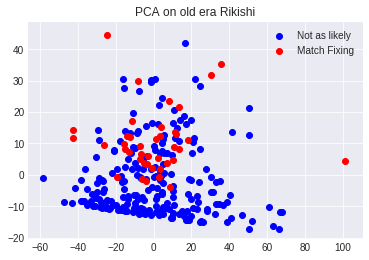

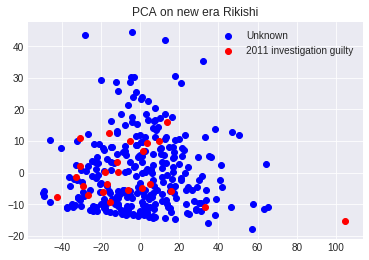

{'copy': True, 'iterated_power': 'auto', 'n_components': 2, 'random_state': None, 'svd_solver': 'auto', 'tol': 0.0, 'whiten': False}


In [35]:
pca = PCA(n_components=2)
old_pca = pca.fit_transform(datatrain_x[:,1:])
x = old_pca[:,0]
y = old_pca[:,1]
asp = ["Not as likely", "Match Fixing"]
for g in range(2):
    ix = datatrain_y == g
    plt.scatter(x[ix],y[ix],color=colorr[g],label = asp[g])
plt.title("PCA on old era Rikishi")
plt.gca().legend()
plt.show()

new_pca = pca.fit_transform(new_rikishi_data[:,1:])
x = new_pca[:,0]
y = new_pca[:,1]
asp = ["Unknown", "2011 investigation guilty"]
for g in range(2):
    ix = np.array(colors1) == g
    plt.scatter(x[ix],y[ix],color=colorr[g],label = asp[g])
plt.title("PCA on new era Rikishi")
plt.gca().legend()
plt.show()
print(pca.fit(new_rikishi_data[:,1:]).get_params())

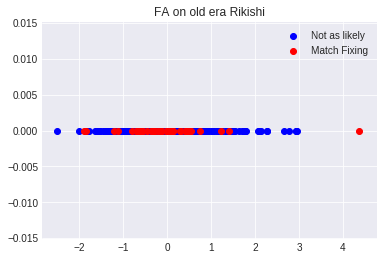

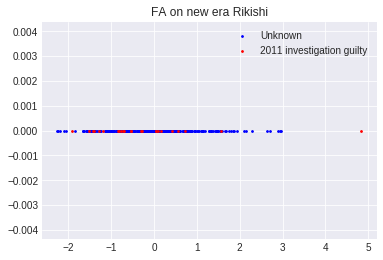

In [48]:
FA = sk.decomposition.FactorAnalysis(n_components=1)
FAold = FA.fit_transform(datatrain_x[:,1:])

x = FAold
# y = FAold[:,1]
asp = ["Not as likely", "Match Fixing"]
for g in range(2):
    ix = datatrain_y == g
    plt.scatter(x[ix],np.zeros(len(x[ix])),color=colorr[g],label = asp[g])
plt.title("FA on old era Rikishi")
plt.gca().legend()

plt.show()

FA = sk.decomposition.FactorAnalysis(n_components=1)
FAnew = FA.fit_transform(new_rikishi_data[:,1:])
x = FAnew
# y = FAnew[:,1]
asp = ["Unknown", "2011 investigation guilty"]
for g in range(2):
    ix = np.array(colors1) == g
    plt.scatter(x[ix],np.zeros(len(x[ix])),s=3,color=colorr[g],label = asp[g])
plt.title("FA on new era Rikishi")
plt.gca().legend()
plt.show()

## Conclusion

Based off of the match data as well as data about the rikishi that we have, we can see that there are still wrestlers with similar attributes to those that were caught cheating in the past according to Naive Bayes Classification (that has a 90% accuracy). There is clearly less now than there was in the past. This lines up with the project done in the past, where we saw the rate of 7-7 match wins drop. We know of at least 23 or 22 rikishi that were caught match-fixing in 2011 which would make up about half of the people found in this iteration. *to do - check the list of proposed cheaters vs those who were actually expelled from the JSA in 2011. all rikishi names are available. This hopefully will confirm more the algorithms used in this project.

In [49]:
print(len(Gaussian_predicted_rikishi))

49
